In [1]:
import json
from pathlib import Path
from src.cross_validation import parse_cd_hit_clusters
from rdkit import Chem
from tqdm import tqdm
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
)
import matplotlib.pyplot as plt

In [2]:
dir = "/home/stef/hiec/artifacts/clustering"
dataset = 'sprhea'
toc = 'v3_folded_pt_ns'
strats = ['rcmcs', 'esm', 'gsi', 'blosum']
cutoffs = [
    (80, 60, 40),
    (99, 98, 97, 95),
    (35, 30, 25),
    (80, 60, 40)
]

In [3]:
for strat, cuts in zip(strats, cutoffs):
    for c in cuts:
        path = Path(dir) / f"{dataset}_{toc}_{strat}_{c}.json"
        with open(path) as f:
            data = json.load(f)

        print(f"{strat} {c}: {len(set(data.values()))}")

rcmcs 80: 2528
rcmcs 60: 1351
rcmcs 40: 758
esm 99: 9382
esm 98: 5768
esm 97: 3310
esm 95: 691
gsi 35: 8332
gsi 30: 2656
gsi 25: 334
blosum 80: 716
blosum 60: 72
blosum 40: 69


In [78]:
def score(x : np.ndarray) -> float:
    return sum(x) / len(x)

def bootstrap_score(metric: callable) -> callable:
    def f(x : np.ndarray, *args) -> tuple[float, float]:
        scores = []
        for _ in range(5):
            idx = np.random.choice(len(x), len(x), replace=True)
            scores.append(metric(x[idx], *args))

        return metric(x), np.std(scores)
    return f

bs_score = bootstrap_score(score)

x = np.array([1, 0, 1, 1, 0, 1, 0, 1, 1, 0])
bs_score(x)
            

(np.float64(0.6), np.float64(0.10198039027185568))

In [5]:
fn = '/projects/p30041/spn1560/hiec/results/predictions/clipzyme/sprhea_v3_folded_pt_ns_rcmcs_outer_fold/target_output.parquet'
df = pd.read_parquet(fn)
df.head()

,protein_idx,reaction_idx,pid,rid,y,logits
0,16113,5226,Q09KQ6,16449,1,0.643928
1,21408,5226,Q9CZU6,16449,0,0.586794
2,7098,5226,Q5XI78,16449,0,0.496528
3,11061,5226,Q8RXV3,16449,0,0.494431
4,24151,5226,O30418,16449,0,0.567291


In [6]:
(df['y'] == (df['logits'] > 0.5)).mean()

np.float64(0.724076837001119)

In [7]:
roc_auc_score(df['y'], df['logits'])

0.7279638045220533

In [8]:
df['y'].mean(), len(df)

(np.float64(0.4842409548675867), 10724)

In [9]:
fn2 = '/projects/p30041/spn1560/hiec/results/predictions/8a155bc5673b4c6aa8667dd55755fe0b/target_output.parquet'
df2 = pd.read_parquet(fn2)
df2.head()

,protein_idx,reaction_idx,pid,rid,y,logits
0,16113,5226,Q09KQ6,16449,1,9.999980e-01
1,21408,5226,Q9CZU6,16449,0,2.327771e-08
2,7098,5226,Q5XI78,16449,0,1.028115e-11
3,11061,5226,Q8RXV3,16449,0,6.455649e-12
4,24151,5226,O30418,16449,0,1.486794e-10


In [10]:
roc_auc_score(df2['y'], df2['logits'])

0.9611057129009355

In [11]:
pairs = set(zip(df['protein_idx'], df['reaction_idx']))
pairs2 = set(zip(df2['protein_idx'], df2['reaction_idx']))
pairs ^ pairs2

set()

In [12]:
pairs = set(zip(df['pid'], df['rid']))
pairs2 = set(zip(df2['pid'], df2['rid']))
pairs ^ pairs2

set()

In [28]:
fni = '/projects/p30041/spn1560/hiec/results/predictions/95963b479bb9434ba0c4fb43a05dc7a4/target_output.parquet'
dfi = pd.read_parquet(fni)
dfi.head()

,protein_idx,reaction_idx,pid,rid,y,logits
0,222,187,Q9KJ20,7694,1,0.999964
1,223,187,Q83WC3,7694,1,0.999654
2,224,187,Q9KJ21,7694,1,0.998847
3,13363,187,Q9KJ22,7694,1,0.999877
4,13364,187,Q7U4Z8,7694,1,0.999670


In [30]:
roc_auc_score(dfi['y'], dfi['logits'])

0.9548395691667799

In [13]:
fnbn = '/projects/p30041/spn1560/hiec/results/predictions/clip_torch_bn/sprhea_v3_folded_pt_ns_rcmcs_outer_fold/target_output.parquet'
dfbn = pd.read_parquet(fnbn)
dfbn.head()

,protein_idx,reaction_idx,pid,rid,y,logits
0,16113,5226,Q09KQ6,16449,1,9.986486e-01
1,21408,5226,Q9CZU6,16449,0,1.045536e-04
2,7098,5226,Q5XI78,16449,0,1.836148e-07
3,11061,5226,Q8RXV3,16449,0,1.734039e-11
4,24151,5226,O30418,16449,0,9.811359e-01


In [14]:
roc_auc_score(dfbn['y'], dfbn['logits'])

0.9147337122629683

In [31]:
fni2 = '/projects/p30041/spn1560/hiec/results/predictions/clipzyme/sprhea_v3_folded_pt_ns_rcmcs_inner_fold_1_of_3/target_output.parquet'
dfi2 = pd.read_parquet(fni2)
dfi2.head()

,protein_idx,reaction_idx,pid,rid,y,logits
0,222,187,Q9KJ20,7694,1,0.707570
1,223,187,Q83WC3,7694,1,0.698980
2,224,187,Q9KJ21,7694,1,0.700994
3,13363,187,Q9KJ22,7694,1,0.649789
4,13364,187,Q7U4Z8,7694,1,0.624836


In [32]:
roc_auc_score(dfi2['y'], dfi2['logits'])

0.9051656582995725

<Axes: xlabel='epoch'>

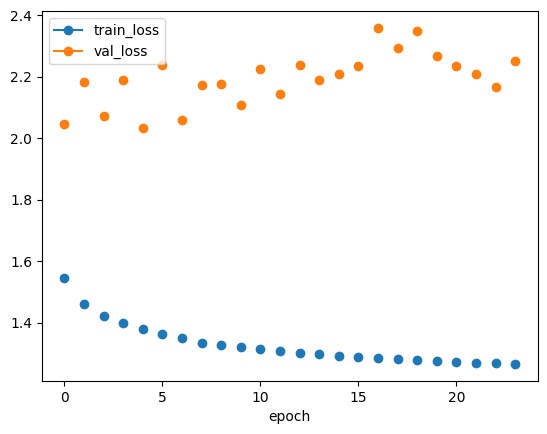

In [15]:
fn = '/projects/p30041/spn1560/hiec/results/runs/clip_torch_bn/sprhea_v3_folded_pt_ns_rcmcs_outer_fold/metrics.csv'
df = pd.read_csv(fn)
df.plot(x='epoch', y=['train_loss', 'val_loss'], marker='o')